# Comparison to modified cosine score
- using `matchms` implementation

In [1]:
import os
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ms2deepscore import SpectrumBinner
from ms2deepscore.models import SiameseModel

path_root = os.path.dirname(os.path.dirname(os.getcwd()))
path_data = os.path.join(path_root, "Data")

## Import test data

In [2]:
import pickle
outfile = os.path.join(path_data, 'GNPS_all', 'ALL_GNPS_positive_test_split_210301.pickle')
with open(outfile, 'rb') as file:
    spectrums_test = pickle.load(file)

print(f"{len(spectrums_test)} spectrums in test data.")

3601 spectrums in test data.


In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_intensity, select_by_mz
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import require_minimum_number_of_peaks

def peak_processing(spectrum):
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_intensity(spectrum, intensity_from=0.005)
    spectrum = select_by_mz(spectrum, mz_from=10, mz_to=1000)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=500)
    return spectrum

In [4]:
spectrums_test = [peak_processing(s) for s in spectrums_test]

## Compute modified Cosine similarities

In [5]:
from matchms import calculate_scores
from matchms.similarity import ModifiedCosine

modcos_similarity = ModifiedCosine(tolerance = 0.005)

scores = calculate_scores(spectrums_test, spectrums_test, modcos_similarity, is_symmetric=True)

In [6]:
scores.scores.shape

(3601, 3601)

## Get reference scores

In [7]:
filename = os.path.join(path_data, 'ALL_GNPS_210125_positive_tanimoto_scores.pickle')
tanimoto_df = pd.read_pickle(filename)
tanimoto_df.head()

,TXZUPPVCNIMVHW,DGYASNDHNSXGSL,JWYUFVNJZUSCSM,ZQXBVPNSSGEUCM,WIOKWEJDRXNVSH,NJMQSVWMCODQIP,VBFKEZGCUWHGSK,KJAYXCCGPDNITQ,NTAHMPNXQOYXSX,YALMHTJLWDGANA,...,DCPZWPYLSMMJKM,BFZHCUBIASXHPK,IYUIDAWSRJAFII,YMGXBGVMAOTRFZ,ZOVBJSDLILDXCH,ZBAVIUQLFUYWMT,LBZHBTVSBILXAE,FQXXSQDCDRQNQE,PKKTXAMCHLIVDS,HDDNZVWBRRAOGK
TXZUPPVCNIMVHW,1.000000,0.351169,0.097595,0.454490,0.232465,0.350913,0.220788,0.369819,0.553414,0.488411,...,0.245836,0.197547,0.319240,0.170619,0.419412,0.111339,0.502242,0.609171,0.456767,0.364198
DGYASNDHNSXGSL,0.351169,1.000000,0.095344,0.311426,0.266393,0.306679,0.187037,0.241550,0.352905,0.346228,...,0.239921,0.196926,0.248181,0.224319,0.328424,0.134894,0.371523,0.395833,0.325097,0.267617
JWYUFVNJZUSCSM,0.097595,0.095344,1.000000,0.087488,0.096552,0.089779,0.075710,0.078571,0.101093,0.111277,...,0.087171,0.076667,0.090069,0.086042,0.097539,0.082902,0.100224,0.097547,0.091977,0.091603
ZQXBVPNSSGEUCM,0.454490,0.311426,0.087488,1.000000,0.158416,0.403968,0.223629,0.428328,0.476427,0.356584,...,0.190833,0.303226,0.309870,0.151724,0.382889,0.200405,0.419784,0.455195,0.301105,0.505532
WIOKWEJDRXNVSH,0.232465,0.266393,0.096552,0.158416,1.000000,0.170429,0.115108,0.148259,0.213307,0.193948,...,0.235054,0.100985,0.156159,0.146067,0.189189,0.065600,0.208011,0.223117,0.272388,0.147978


In [8]:
inchikey_idx_test = np.zeros(len(spectrums_test))
for i, spec in enumerate(spectrums_test):
    inchikey_idx_test[i] = np.where(tanimoto_df.index.values == spec.get("inchikey")[:14])[0]

inchikey_idx_test = inchikey_idx_test.astype("int")

scores_ref = tanimoto_df.values[np.ix_(inchikey_idx_test[:], inchikey_idx_test[:])].copy()

## min_match=2

In [9]:
scores_scores = scores.scores["score"]
scores_matches = scores.scores["matches"]
scores_minmatch2 = scores_scores * (scores_matches >=2)

In [10]:
scores_minmatch2.shape

(3601, 3601)

In [17]:
def precision_recall_plot(scores_test, scores_ref,
                          high_sim_threshold=0.6,
                          n_bins = 20):
    """Basic precision recall plot"""
    precisions = []
    recalls = []

    above_thres_total = np.sum(scores_ref >= high_sim_threshold)
    max_score = scores_test.max()
    min_score = scores_test.min()
    score_thresholds = np.linspace(min_score, max_score, n_bins+1)
    for low in score_thresholds:
        idx = np.where(scores_test>=low)
        above_thres = np.sum(scores_ref[idx] >= high_sim_threshold)
        below_thres = np.sum(scores_ref[idx] < high_sim_threshold)

        precisions.append(above_thres/(below_thres+above_thres))
        recalls.append(above_thres/above_thres_total)

    plt.figure(figsize=(6,5), dpi=120)
    plt.plot(recalls, precisions, "o--", color="crimson", label="precision/recall")
    #plt.plot(score_thresholds, precisions, "o--", color="crimson", label="precision")
    #plt.plot(score_thresholds, recalls, "o--", color="dodgerblue", label="recall")
    plt.legend()
    plt.xlabel("recall", fontsize=12)
    plt.ylabel("precision", fontsize=12)
    plt.title(f"precision/recall (high-similarity if Tanimoto > {high_sim_threshold })")
    plt.grid(True)
    
    return precisions, recalls

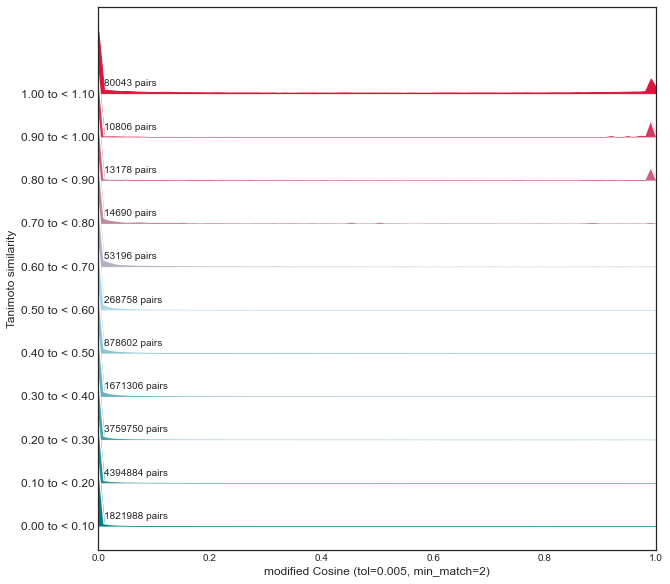

In [29]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, scores_minmatch2, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity",
                       compare_score_name="modified Cosine (tol=0.005, min_match=2)")
plt.savefig("histogram_modcos_minmatch2_210311_ALL_GNPS_testset.pdf")

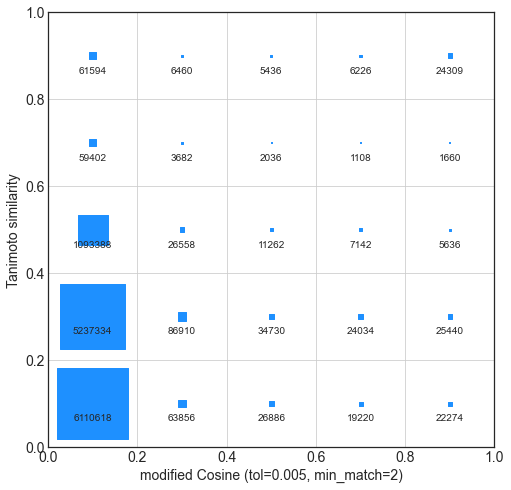

In [13]:
from ms2deepscore.plotting import create_confusion_matrix_plot

fig = create_confusion_matrix_plot(scores_ref, scores_minmatch2, n_bins=5,
                                   ref_score_name="Tanimoto similarity",
                                   compare_score_name="modified Cosine (tol=0.005, min_match=2)",
                                   max_square_size=5000, color_by_reference_fraction=False)
plt.savefig("confusion_modcos_minmatch2_210323_ALL_GNPS_testset.pdf")

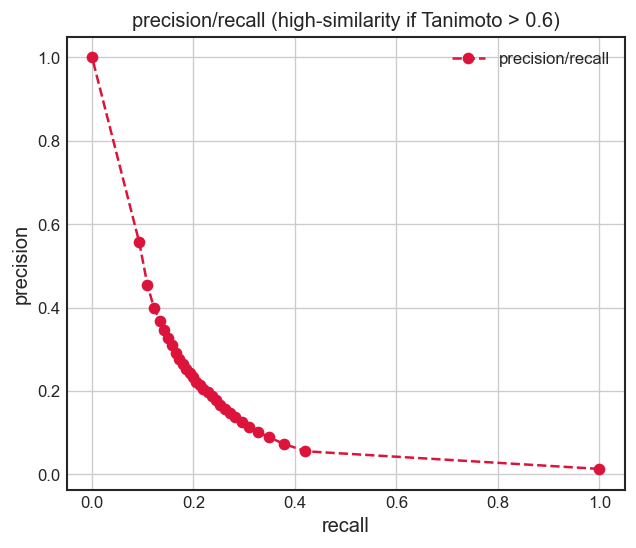

In [19]:
precisions, recalls = precision_recall_plot(scores_minmatch2, scores_ref, high_sim_threshold=0.6, n_bins=30)
plt.savefig("precision_recall_modcos_minmatch2_230323.pdf")

In [20]:
np.save("recall_tanimoto06_modcos_mm2.npy", np.array(recalls))
np.save("precision_tanimoto06_modcos_mm2.npy", np.array(precisions))

## min_match=6

In [14]:
scores_scores = scores.scores["score"]
scores_matches = scores.scores["matches"]
scores_minmatch6 = scores_scores * (scores_matches >=6)

In [15]:
scores_minmatch6.shape, scores_matches.shape

((3601, 3601), (3601, 3601))

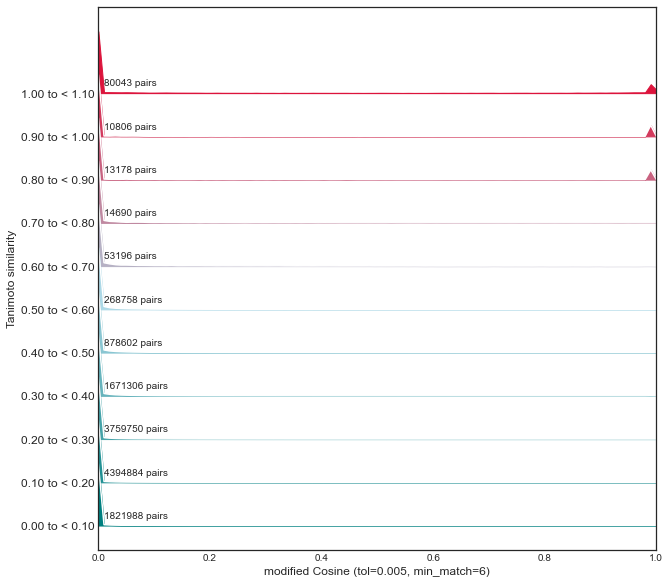

In [22]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, scores_minmatch6, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity",
                       compare_score_name="modified Cosine (tol=0.005, min_match=6)")
plt.savefig("histogram_modcos_210311_ALL_GNPS_testset.pdf")

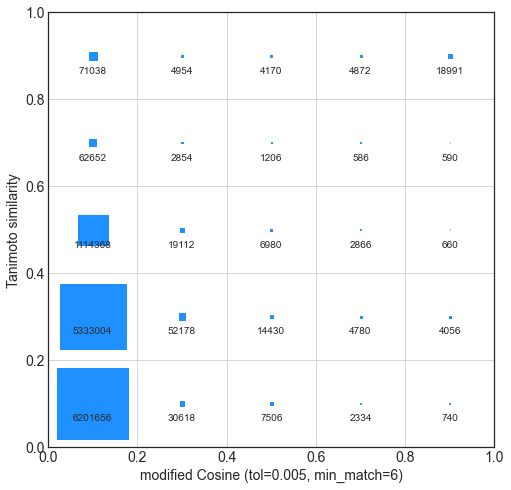

In [21]:
#from ms2deepscore.plotting import create_confusion_matrix_plot

fig = create_confusion_matrix_plot(scores_ref, scores_minmatch6, n_bins=5,
                                   ref_score_name="Tanimoto similarity",
                                   compare_score_name="modified Cosine (tol=0.005, min_match=6)",
                                   max_square_size=5000, color_by_reference_fraction=False)
plt.savefig("confusion_modcos_minmatch6_210323_ALL_GNPS_testset.pdf")

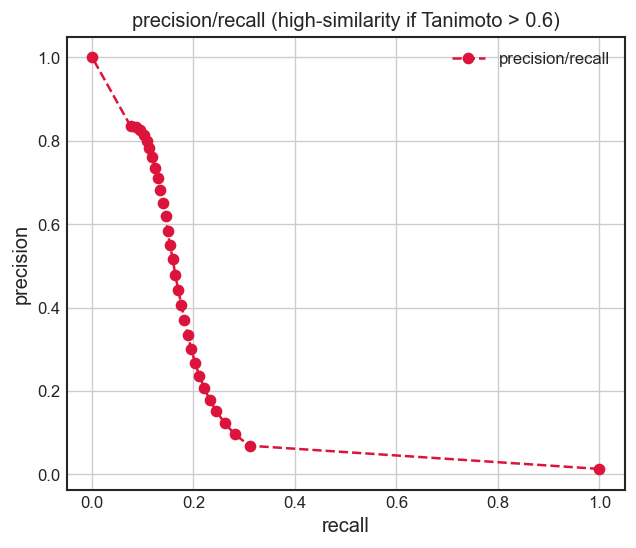

In [22]:
precisions_mm6, recalls_mm6 = precision_recall_plot(scores_minmatch6, scores_ref, high_sim_threshold=0.6, n_bins=30)
plt.savefig("precision_recall_modcos_minmatch6_230323.pdf")

In [23]:
np.save("recall_tanimoto06_modcos_mm6.npy", np.array(recalls_mm6))
np.save("precision_tanimoto06_modcos_mm6.npy", np.array(precisions_mm6))

## min_match=10

In [35]:
scores_scores = scores.scores["score"]
scores_matches = scores.scores["matches"]
scores_minmatch10 = scores_scores * (scores_matches >=10)

In [36]:
scores_minmatch10.shape, scores_matches.shape

((3601, 3601), (3601, 3601))

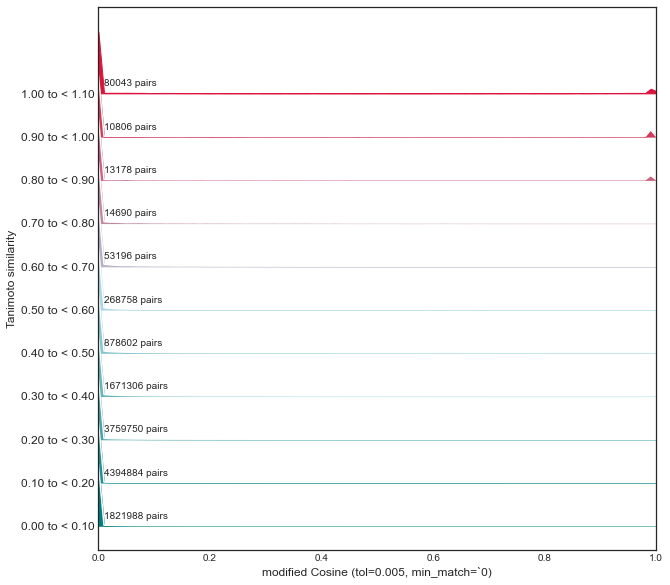

In [37]:
from ms2deepscore.plotting import create_histograms_plot

create_histograms_plot(scores_ref, scores_minmatch10, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity",
                       compare_score_name="modified Cosine (tol=0.005, min_match=`0)")
plt.savefig("histogram_modcos_minmatch10_210311_ALL_GNPS_testset.pdf")

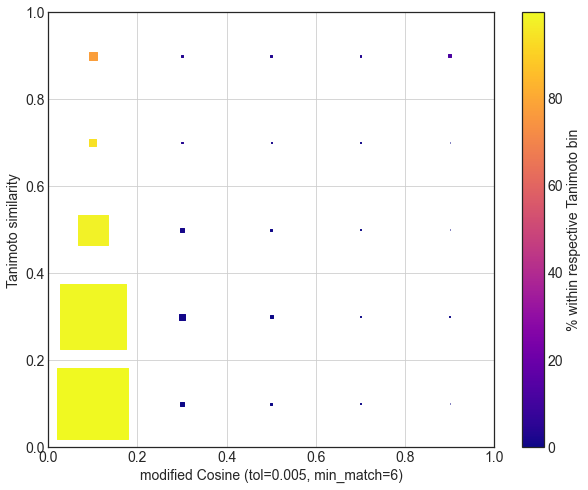

In [38]:
from ms2deepscore.plotting import create_confusion_matrix_plot

fig = create_confusion_matrix_plot(scores_ref, scores_minmatch10, n_bins=5,
                                   ref_score_name="Tanimoto similarity",
                                   compare_score_name="modified Cosine (tol=0.005, min_match=6)",
                                   max_square_size=5000)
plt.savefig("confusion_modcos_minmatch10_210311_ALL_GNPS_testset.pdf")

In [39]:
high_sim_threshold = 0.6

precisions = []
recalls = []

above_thres_total = np.sum(scores_ref >= high_sim_threshold)
score_thresholds = np.linspace(0.05,1,20)
for low in score_thresholds:
    idx = np.where(scores_minmatch10>low)
    above_thres = np.sum(scores_ref[idx] >= high_sim_threshold)
    below_thres = np.sum(scores_ref[idx] < high_sim_threshold)
    
    precisions.append(above_thres/(below_thres+above_thres))
    recalls.append(above_thres/above_thres_total)
    

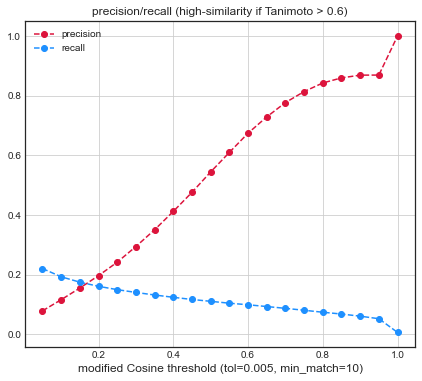

In [40]:
plt.figure(figsize=(7,6))
plt.plot(score_thresholds, precisions, "o--", color="crimson", label="precision")
plt.plot(score_thresholds, recalls, "o--", color="dodgerblue", label="recall")
plt.legend()
plt.xlabel("modified Cosine threshold (tol=0.005, min_match=10)", fontsize=12)
plt.title(f"precision/recall (high-similarity if Tanimoto > {high_sim_threshold })")
plt.grid(True)